Plot figures 3 and 4.

In [1]:
import fsspec
import xarray as xr
import os
import vcm
import matplotlib.pyplot as plt
import numpy as np
import fv3viz
from vcm.catalog import catalog
plt.rcParams['figure.dpi'] = 200
xr.set_options(keep_attrs=True)

In [2]:
root_url = 'gs://vcm-ml-experiments/default/2022-09-20/ml-on-fine-res-train-nn-precip-rs-trial-0/offline_diags'
seed = 5

In [3]:
grid = catalog['grid/c48'].to_dask().load()

In [4]:
def open_diags(url):
    full_path = os.path.join(url,  'offline_diagnostics.nc')
    return vcm.open_remote_nc(fsspec.filesystem('gs'), full_path)

In [5]:
ds = open_diags(f'{root_url}/model{seed}')
ds['pressure'].attrs = {'long_name': 'Pressure', 'units': 'hPa'}
ds['pressure'] = ds.pressure / 100
ds = xr.merge([ds, grid])
ds = ds.sel(derivation=['target', 'predict'])
ds['derivation'] = ['a) target', 'b) prediction']

### Plot zonal R^2

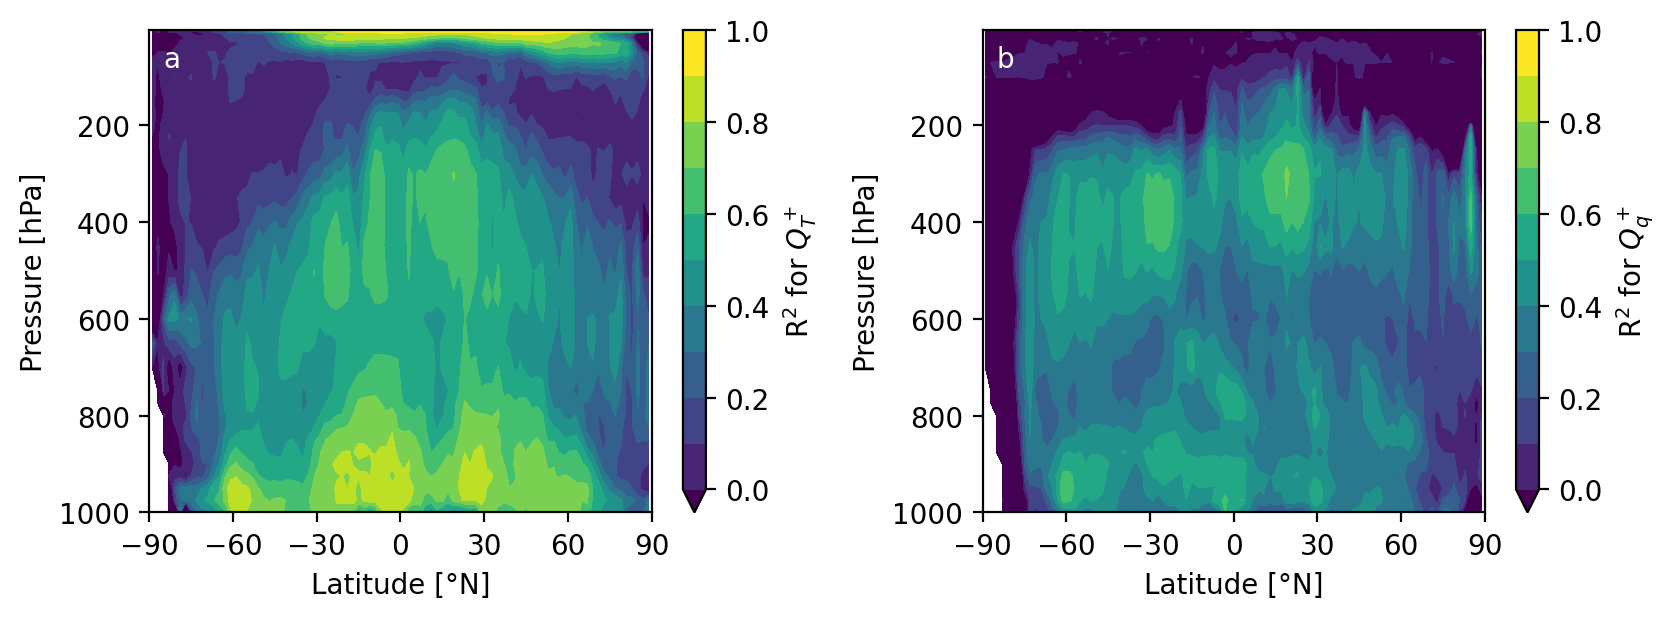

In [6]:
q1_r2 = ds.q1_r2_pressure_level_zonal_avg_global.rename('R$^2$ for $Q_T^+$')
q2_r2 = ds.q2_r2_pressure_level_zonal_avg_global.rename('R$^2$ for $Q_q^+$')
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.2))
for i, da in enumerate([q1_r2, q2_r2]):
    da.plot.contourf(ax=axes[i], y='pressure', yincrease=False, vmin=0, vmax=1, levels=np.arange(0, 1.1, 0.1))
for ax in axes:
    ax.set_title('')
    ax.set_xticks(np.arange(-90, 91, 30))
    ax.set_xlabel('Latitude [°N]')
axes[0].text(-85, 80, 'a', color='white')
axes[1].text(-85, 80, 'b', color='white')
fig.tight_layout()


### Plot snapshot of column integrated heating

(<Figure size 1200x800 with 1 Axes>,
 array(<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7f7ff46d22b0>,
       dtype=object),
 None)

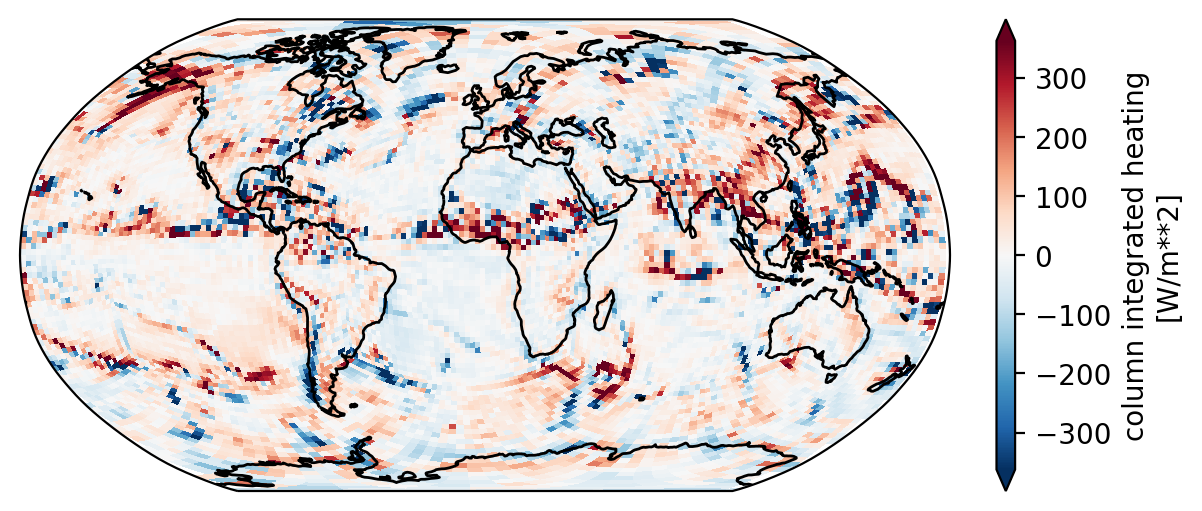

In [7]:
error = ds.column_integrated_Q1_snapshot.sel(derivation='b) prediction') - ds.column_integrated_Q1_snapshot.sel(derivation='a) target')
plotme = xr.merge([error, grid])
fv3viz.plot_cube(plotme, 'column_integrated_Q1_snapshot')

### Compute RMSE of snapshot prediction

In [8]:
rmse = np.sqrt(vcm.weighted_average(error**2, grid.area))
rmse

<xarray.DataArray 'column_integrated_Q1_snapshot' ()>
array(166.5348582)
Coordinates:
    time_snapshot  object 2016-08-05 17:00:00
Attributes:
    long_name:  column integrated heating
    units:      W/m**2

Text(0.38, 0.15, 'RMSE=166.5 W/m$^2$')

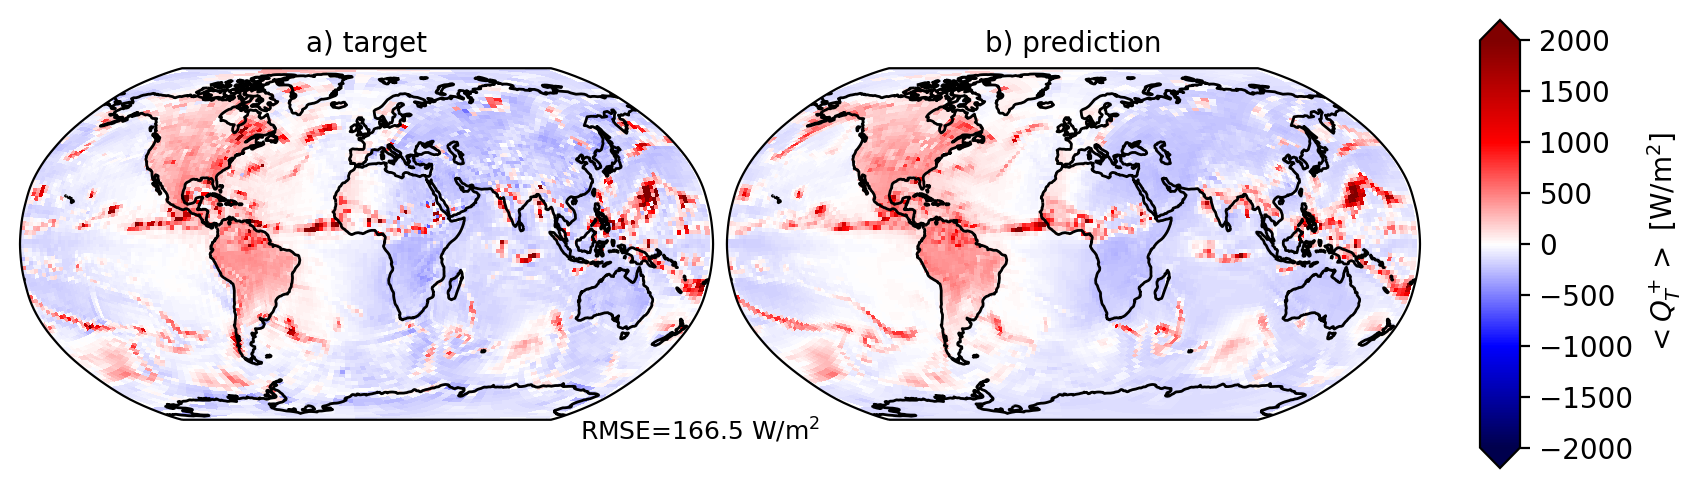

In [9]:
rmse_val = rmse.values.item()
ds['column_integrated_Q1_snapshot'].attrs = {'long_name': '$<Q_T^+>$', 'units': 'W/m$^2$'}
fg = fv3viz.plot_cube(ds, 'column_integrated_Q1_snapshot', col='derivation', vmin=-2000, vmax=2000, cmap='seismic')[-1]
fg.set_titles(template='{value}')
fg.fig.set_size_inches((10, 2.8))
fg.fig.text(0.38, 0.15, f'RMSE={rmse_val:.1f} W/m$^2$', fontsize=9)

In [10]:
ds.time_snapshot

<xarray.DataArray 'time_snapshot' ()>
array(cftime.DatetimeJulian(2016, 8, 5, 17, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time_snapshot  object 2016-08-05 17:00:00